See Figure 2 of Kirch2020, which was the starting point for this work.

The intent is to have summary plots for EDM limits, first for hadronic EDM limits.

Open questions:  
How to deal with confidence limits uniformly?  
How to document the conversions?  
Which conversions to use?  

Color options: https://matplotlib.org/3.1.0/gallery/color/named_colors.html

In [1]:
import os
import copy as _cp
import numpy as _np
import matplotlib.pyplot as plt
import matplotlib.ticker
import schiff as _schiff

%config InlineBackend.figure_format = 'retina'

# Hadronic limits 

In [2]:
class EDMLimit:
    """A measured permament electric dipole moment limit.
    
    This classes organizes an experimental result.
    
    Attributes:
        year: float, year of publication
        ref: str, short paper reference in NameYear format
        edm_e_cm: float, reported EDM limit in e*cm units
        system: str, identify specific EDM systems, e.g. "neutron"
    """
    system = None

    def __init__(self, year, edm_e_cm, ref):
        self.year = year
        self.edm_e_cm = edm_e_cm
        self.ref = ref
    
    @property
    def theta_QCD(self):
        pass
    
    @property
    def cEDM(self):
        pass

    @property
    def new_particle_mass_from_cEDM(self):
        return chromo_EDM_limits_on_new_particle_mass(self.cEDM)


class NeutronLimit(EDMLimit):
    """Measured Neutron EDM limit.
    """
    system = "neutron"
        
    def __init__(self, year, edm_e_cm, ref):
        super().__init__(year, edm_e_cm, ref)            

    @property
    def theta_QCD(self):
        """
        The conversion from the neutron EDM limit 
        to a limit on the theta_QCD value is 
        from PRL 115, 062001 (2015), Eq. 19.
        """
        n_edm_theta_factor = 0.0039 # units of [e*fm*theta_QCD]
        factor_in_cm = n_edm_theta_factor*(1e2/1e15)
        return self.edm_e_cm/factor_in_cm

    @property
    def cEDM(self):
        """Gets the bound on chrome-EDM d_d + 0.5 d_u from a neutron EDM bound.

        Note this is not d_u - d_d as in the following cEDM bound calculations.

        See abstract of Pospelov2001 (https://arxiv.org/abs/hep-ph/0010037).
        Note that we take the prefactor 1+/-0.5 to be 1.


        Returns:
            bound of d_d + 0.5 d_u in cm.
        """
        return self.edm_e_cm/0.55


class HgLimit(EDMLimit):
    """Measured Hg-199 EDM limit.
    """
    system = "Hg"
    
    def __init__(self, year, edm_e_cm, ref):
        super().__init__(year, edm_e_cm, ref)            

    @property
    def theta_QCD(self):
        """
        The conversion from a Hg-199 EDM limit 
        to a limit on the theta_QCD value is 
        from Graner, et al. PRL 116, 161601 (2016).  The ratio 
        of the Hg-199 EDM to the value of theta_QCD
        is used to convert previous Hg-199 EDM 
        measurements to their theta_QCD limit.
        """
        graner_ratio = 7.4e-30/1.5e-10  
        return self.edm_e_cm/graner_ratio    

    @property
    def cEDM(self):
        """Gets the bound on chrome-EDM d_u - d_d from a Hg EDM bound.
        """
        return cEDM_Hg(self.edm_e_cm)


def cEDM_Hg(d_Hg):
    """Gets the bound on chrome-EDM d_u - d_d from a Hg EDM bound.

    See Graner2016 Table III and Eq. 5.

    Args:
        d_Hg: Hg EDM bound in e*cm.

    Returns:
        bound of d_u - d_d in cm.
    """
    factor = 5.7e-27/7.4e-30
    return d_Hg*factor
    
    
def chromo_EDM_limits_on_new_particle_mass(d_q=1e-27):
    """1 loop level mass limits in TeV from quark chromo EDM limits.
    This function comes from email exchanges Andrew had with Jordy De Vries
    in Fall, 2021.  This allows one to connect hadronic TSV sensitivity
    to sensitivity to new particles through quark chromo EDM limits.
    For unit conversions hbar * c = 1 = 197 MeV fm
    So you can express an EDM limit like:
    10^-14 fm in units of inverse energy as
    10^-14 fm = 10^-14 fm/(hbar c) = 10^-14 fm/(197 MeV fm)
    = 10^-14/(197) MeV^-1
    Args:
        d_q: float, quark chromo EDM limit in cm.
    Returns:
        float, particle mass sensitivity scale in TeV.
    """
    alpha = 1/137  # fine structure constant
    m_q = 5  # MeV - very approximate up quark mass

    prefactor = alpha * m_q/_np.pi

    cm_to_fm = 10**15/10**2
    d_q_fm = d_q * cm_to_fm

    fm_to_inv_MeV = 1/197
    d_q_inv_MeV = d_q_fm * fm_to_inv_MeV

    MeV_to_TeV = (1./1e-6)*(1e-12/1.)

    return MeV_to_TeV * _np.sqrt(prefactor * 1/d_q_inv_MeV)
    
    
class XeLimit(EDMLimit):
    """Measured Xe EDM limit.
    """
    system = "Xe"
        
    def __init__(self, year, edm_e_cm, ref):
        super().__init__(year, edm_e_cm, ref)            

    @property
    def theta_QCD(self):
        """
        Rough estimate from Table V of 
        https://doi.org/10.1103/PhysRevC.91.035502.

        Note that Eq. 19 and 20 of Flambaum2020a says 
        Xe sensitivity ~ Hg, different from
        the 10x smaller sensitivity that is assumed here.
        """
        Hg_factor = 7.4e-30/1.5e-10  # PRL 116, 161601 (2016)
        Xe_Hg_factor = 10.
        return self.edm_e_cm * Xe_Hg_factor/Hg_factor 

    @property
    def cEDM(self):
        """Gets the bound on chrome-EDM d_u - d_d from a Xe EDM bound.

        Uses cEDM_Hg and estimation from Table V of Chupp2015, https://doi.org/10.1103/PhysRevC.91.035502.

        Note that Eq. 19 and 20 of Flambaum2020a says Xe sensitivity ~ Hg, different from
        the 10x smaller sensitivity that is assumed here.


        Returns:
            bound on (d_u - d_d) in cm.
        """
        eff_d_Hg = self.edm_e_cm * 10.
        return cEDM_Hg(eff_d_Hg)    
    
    
class TlFLimit(EDMLimit):
    """Measured TlF EDM limit.
    """
    system = "TlF"
        
    def __init__(self, year, edm_e_cm, ref):
        super().__init__(year, edm_e_cm, ref)            

    @property
    def _schiff_limit(self):
        """Returns the Schiff moment limit from the atomic EDM.
        
        Uses the values for the TlF Schiff moment and EDM 
        given in Table VII of Cho1991.
        
        Returns:
            float, Schiff moment limit in e fm^3
        """
        Cho1991_Schiff_limit = 4e-10  # e fm^3
        Cho1991_TlF_EDM_limit = 2.9e-23  # e cm
        EDM_to_schiff_for_TlF = Cho1991_Schiff_limit/Cho1991_TlF_EDM_limit
        return EDM_to_schiff_for_TlF * self.edm_e_cm
    
    @property
    def theta_QCD(self):
        theta_factor = 0.027  # Flambaum2020a, Eq. 17
        return self._schiff_limit/theta_factor
        
    @property
    def cEDM(self):
        """TlF chromo EDM limit.
        
        See Eq. 18 of Flambaum2020a:
        S(TlF) \approx (12 d_d + 9 d_u) e fm^2.
        This is approximated here as a factor of 10.
        
        Returns:
            bound on (d_u + d_d) in cm.        
        """
        cEDM_factor = 10  # Flambaum2020a, Eq. 18
        return self._schiff_limit/cEDM_factor/1e13


class RaLimit(EDMLimit):
    """Measured Radium-225 EDM limit."""
    
    system = "Ra"
    
    def __init__(self, year, edm_e_cm, ref):
        super().__init__(year, edm_e_cm, ref)

    @property
    def _schiff_limit(self):
        """Returns the Schiff moment limit from the atomic EDM limit.
        
        Dzuba2002a Eq. 16
        
        d(^{225}Ra) = -8.5\times 10^{-17}(S/(e fm^3)) e cm
        which translates to 
        kappa_s = -8.5e-4.  # fm^-2
        
        S = d/kappa_s

        We are considering the absolute value of the atomic EDM,
        so we drop the minus sign from kappa_s below.

        Returns:
            float, Schiff moment limit in e fm^3
        
        """
        kappa_s = 8.5e-4  # fm**-2
        edm_e_fm = self.edm_e_cm * (1e15/1e2)  # convert from e*cm to e*fm
        schiff_moment_limit = edm_e_fm/kappa_s
        return schiff_moment_limit
    
    @property
    def theta_QCD(self): 
        """Limit on the theta QCD parameter.
        
        Flambaum2019 Eq. 11
        S(^{225}Ra) = 1.0 theta_QCD e fm^3
        
        Returns:
            float
        """
        return self._schiff_limit

    @property
    def _g1(self):
        """Limit on g1
        
        From Ban2010 Eq. 7
        S = a1*g*g1, assuming a sole source analysis, i.e. g0=g2=0.
        Ban2010 text:
        g = g\piNN ~ 13.5, see also Engel2013, Table 5.
        """
        # Engel2013 Table 13
        a1 = 6.0
        # Ban2010, see also Table 5, Englel2013, one of 2 values of g given.
        g = 13.5
        g1_limit = self._schiff_limit/(a1*g)  
        return g1_limit

    @property
    def cEDM(self):
        """Limits on quark chromo EDMs
        
        See Pospleov2002
        
        
        Returns:
            bound on (d_u - d_d) in cm.
        """
        return self._g1/(2e14)
    
    
class YbLimit(EDMLimit):
    """Measured Yb EDM limit.
    """
    system = "Yb"
        
    def __init__(self, year, edm_e_cm, ref):
        super().__init__(year, edm_e_cm, ref)

    @property
    def _schiff_limit(self):
        """Returns the Schiff moment limit from the atomic EDM limit.
        
        Flambaum2020a Table III
        
        d(^{171}Yb) = -1.88\times 10^{-17}(S/(e fm^3)) e cm
        which translates to 
        kappa_s = -1.88e-4.  # fm^-2
        
        S = d/kappa_s

        We are considering the absolute value of the atomic EDM,
        so we drop the minus sign from kappa_s below.

        Returns:
            float, Schiff moment limit in e fm^3
        
        """
        kappa_s = 1.88e-4  # fm**-2
        edm_e_fm = self.edm_e_cm * (1e15/1e2)  # convert from e*cm to e*fm
        schiff_moment_limit = edm_e_fm/kappa_s
        return schiff_moment_limit    

    @property
    def theta_QCD(self): 
        """Limit on the theta QCD parameter.
        
        Dzuba2007 Eq. 8, Yb and Hg Schiff moment to CP violation operators
        are about the same.

        Flambaum2020a Table IV
        S(^{199}Hg) = 0.005 theta_QCD e fm^3
        
        Returns:
            float
        """
        theta_QCD_to_Schiff = 0.005
        return self._schiff_limit / theta_QCD_to_Schiff

    @property
    def cEDM(self):
        """Gets the bound on chrome-EDM d_u - d_d from a Yb EDM bound.

        Dzuba2007 Eq. 9, Assumes that Yb EDM sensitivity to CP violation operators
        is 0.6x of the Hg EDM sensitivity.

        Returns:
            bound on (d_u - d_d) in cm.
        """
        d_Yb_equivalent_d_Hg = 0.6
        eff_d_Hg = self.edm_e_cm / d_Yb_equivalent_d_Hg
        return cEDM_Hg(eff_d_Hg)
        

# Load Data

Data is saved in files in the following format:  column one is the year of publication, column two is the EDM limit in units of e\*cm and the final column is the reference key, typically given by the first authors last name and year of publication.

In [3]:
def get_EDM_data(system_cls):
    """Load EDM data from a file.
        
    Args:
        system_cls: system EDMLimit class, e.g. NeutronLimit
        
    Returns:
        list of EDMLimit class instances
    """
    file_path = os.path.join("data", "hadronic",  f"{system_cls.system}.txt")
    data = _np.genfromtxt(file_path, dtype=['<i8', '<f8', 'S11'])
    data = _np.atleast_1d(data)  # needed if the data only has one entry
    EDMs = []
    for measurement in data:
        year = measurement[0]
        edm_limit = measurement[1]
        ref = measurement[2]
        EDMs.append(system_cls(year=year, edm_e_cm=edm_limit, ref=ref))
    return EDMs    

neutron_EDMs = get_EDM_data(NeutronLimit)
tlf_EDMs = get_EDM_data(TlFLimit)
hg_EDMs = get_EDM_data(HgLimit)
xe_EDMs = get_EDM_data(XeLimit)
ra_EDMs = get_EDM_data(RaLimit)
yb_EDMs = get_EDM_data(YbLimit)

In [4]:
class Plottables:
    def __init__(self, EDMs):
        """
        Attributes:
            years
            edms
            thetas
            cedms
            new_ms
            kwargs: dict, for plotting
        
        Args:
            EDMs, list of EDM instances
        """
        self.years = []
        self.edms = []
        self.thetas = []
        self.cedms = []
        self.new_ms = []
        self.populate_lists(EDMs=EDMs)
        self.kwargs = None
    
    def populate_lists(self, EDMs):
        for edm in EDMs:
            self.years.append(edm.year)
            self.edms.append(edm.edm_e_cm)
            self.thetas.append(edm.theta_QCD)
            self.cedms.append(edm.cEDM)
            self.new_ms.append(edm.new_particle_mass_from_cEDM)

            
def save_figures(fig, plot_title):
    """Save pdf and png versions
    
    Args:
        fig: matplotlib Figure instance
        plot_title: str
    """
    plot_name = plot_title + ".pdf"
    plot_path = os.path.join("plots", plot_name)
    fig.savefig(plot_path, bbox_inches='tight')
    plot_name = plot_title + ".png"
    plot_path = os.path.join("plots", plot_name)
    fig.set_facecolor('w')
    fig.savefig(plot_path, dpi=300, transparent=False, bbox_inches='tight')            


# Marker styles
n_kwargs = {'marker':"o", 'color':"royalblue", 'label':"neutron", 
            's':100, 'edgecolor':"b"}
hg_kwargs = {'marker':"*", 'color':"orange", 'label':"Hg", 
            's':100, 'edgecolor':"darkorange"}
xe_kwargs = {'marker':"s", 'color':"indianred", 'label':"Xe", 
            's':100, 'edgecolor':"darkred"}
tlf_kwargs = {'marker':"d", 'color':"yellow", 'label':"TlF", 
            's':100, 'edgecolor':"gold"}
ra_kwargs = {'marker':"x", 'color':"darkgreen", 'label':"Ra", 
            's':100}
yb_kwargs = {'marker':"D", 'color':"darkgray", 'label':"Yb", 
            's':100}

n_vals = Plottables(neutron_EDMs)
n_vals.kwargs = n_kwargs
hg_vals = Plottables(hg_EDMs)
hg_vals.kwargs = hg_kwargs
xe_vals = Plottables(xe_EDMs)
xe_vals.kwargs = xe_kwargs
tlf_vals = Plottables(tlf_EDMs)
tlf_vals.kwargs = tlf_kwargs
ra_vals = Plottables(ra_EDMs)
ra_vals.kwargs = ra_kwargs
yb_vals = Plottables(yb_EDMs)
yb_vals.kwargs = yb_kwargs

hadronic_systems = [n_vals, hg_vals, xe_vals, tlf_vals, ra_vals, yb_vals]

year_i = 1955
year_f = 2024
year_f_electron = 2025

ma_alpha = 0.6
mi_alpha = 0.1


In [5]:
def scatter_plot_loop(ax, systems, value):
    """
    
    Args:
        ax: matplotlib type, "ax"
        systems: list, systems with data to plot
        value: str, type of value to plot.
    """
    for system in systems:
        ax.scatter(system.years, getattr(system, value), **system.kwargs)

# EDM limits of hadronic species

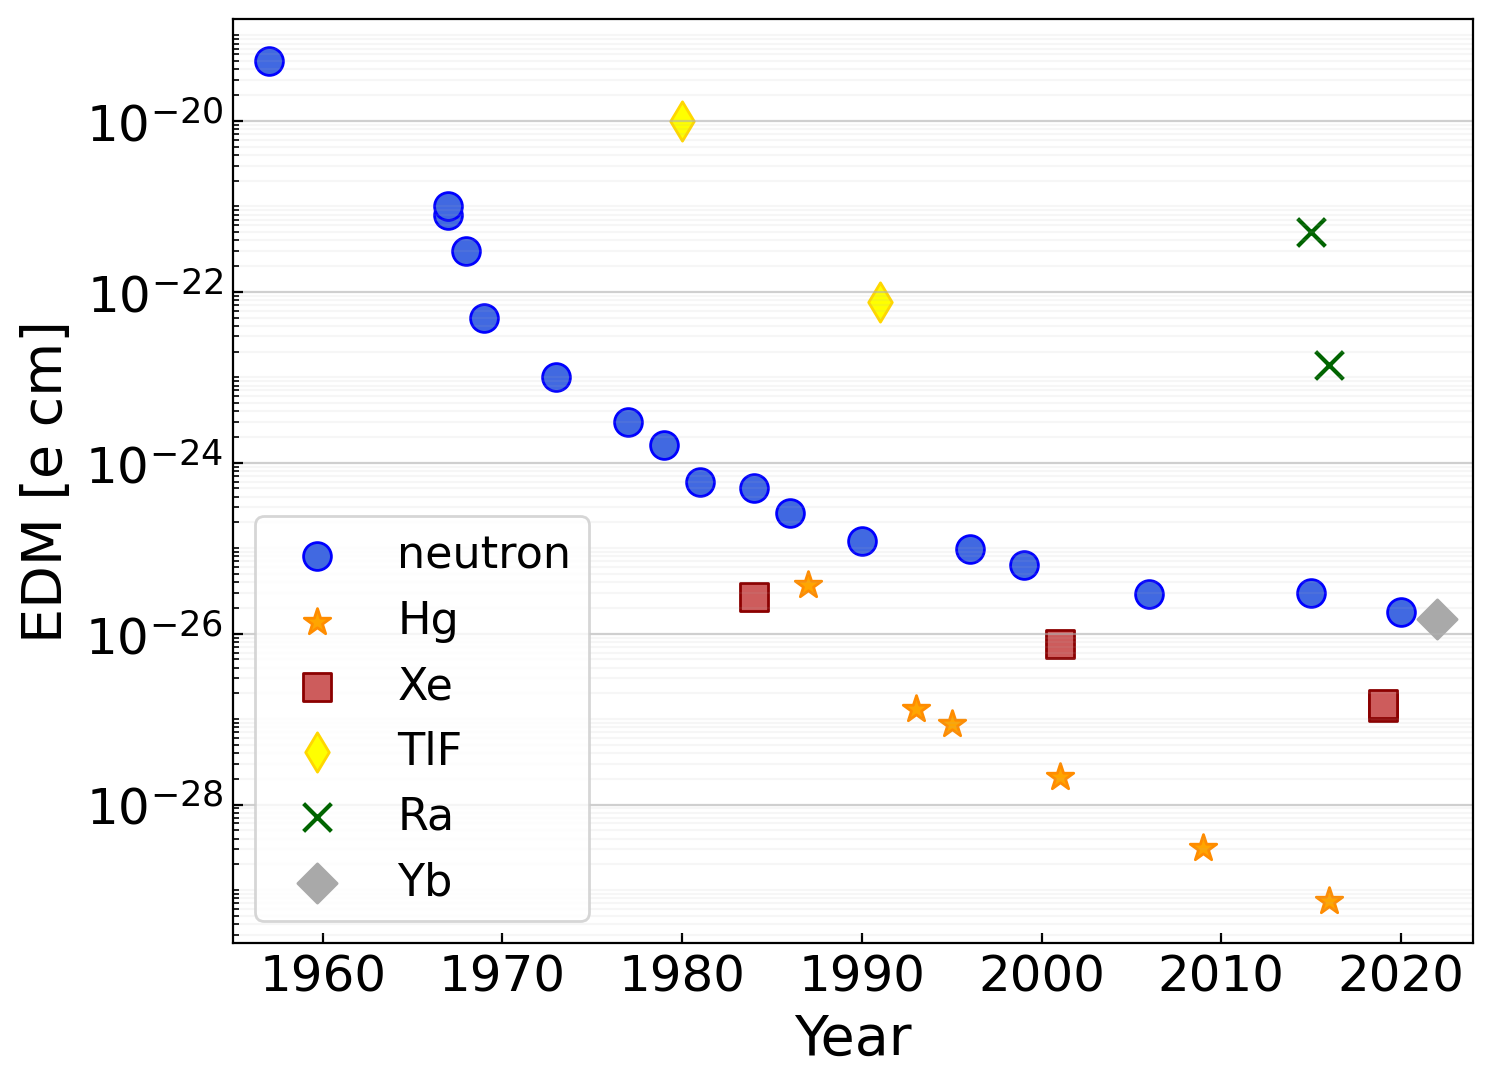

In [6]:
fig, ax = plt.subplots(figsize=(8, 6))

scatter_plot_loop(ax, hadronic_systems, "edms")

ax.set_yscale("log")
ax.set_xlim(year_i, year_f)

locmaj = matplotlib.ticker.LogLocator(base=10.0,  numticks=22)
ax.yaxis.set_major_locator(locmaj)

ax.tick_params(axis="both", which='both', direction="in", labelsize=18)
ax.grid(axis='y', which='major', ls='-', alpha=ma_alpha)
ax.grid(axis='y', which='minor', ls='-', alpha=mi_alpha)

plt.locator_params(axis='y', numticks=10)

locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9),numticks=12)
ax.yaxis.set_minor_locator(locmin)
ax.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())


fontsize = 20
ax.set_xlabel("Year", fontsize=fontsize)
ax.set_ylabel("EDM [e cm]", fontsize=fontsize)
ax.legend(numpoints=1, fontsize=16)#, framealpha=1)

save_figures(fig=fig, plot_title="hadronic-edm-limits")

# Theta QCD bounds

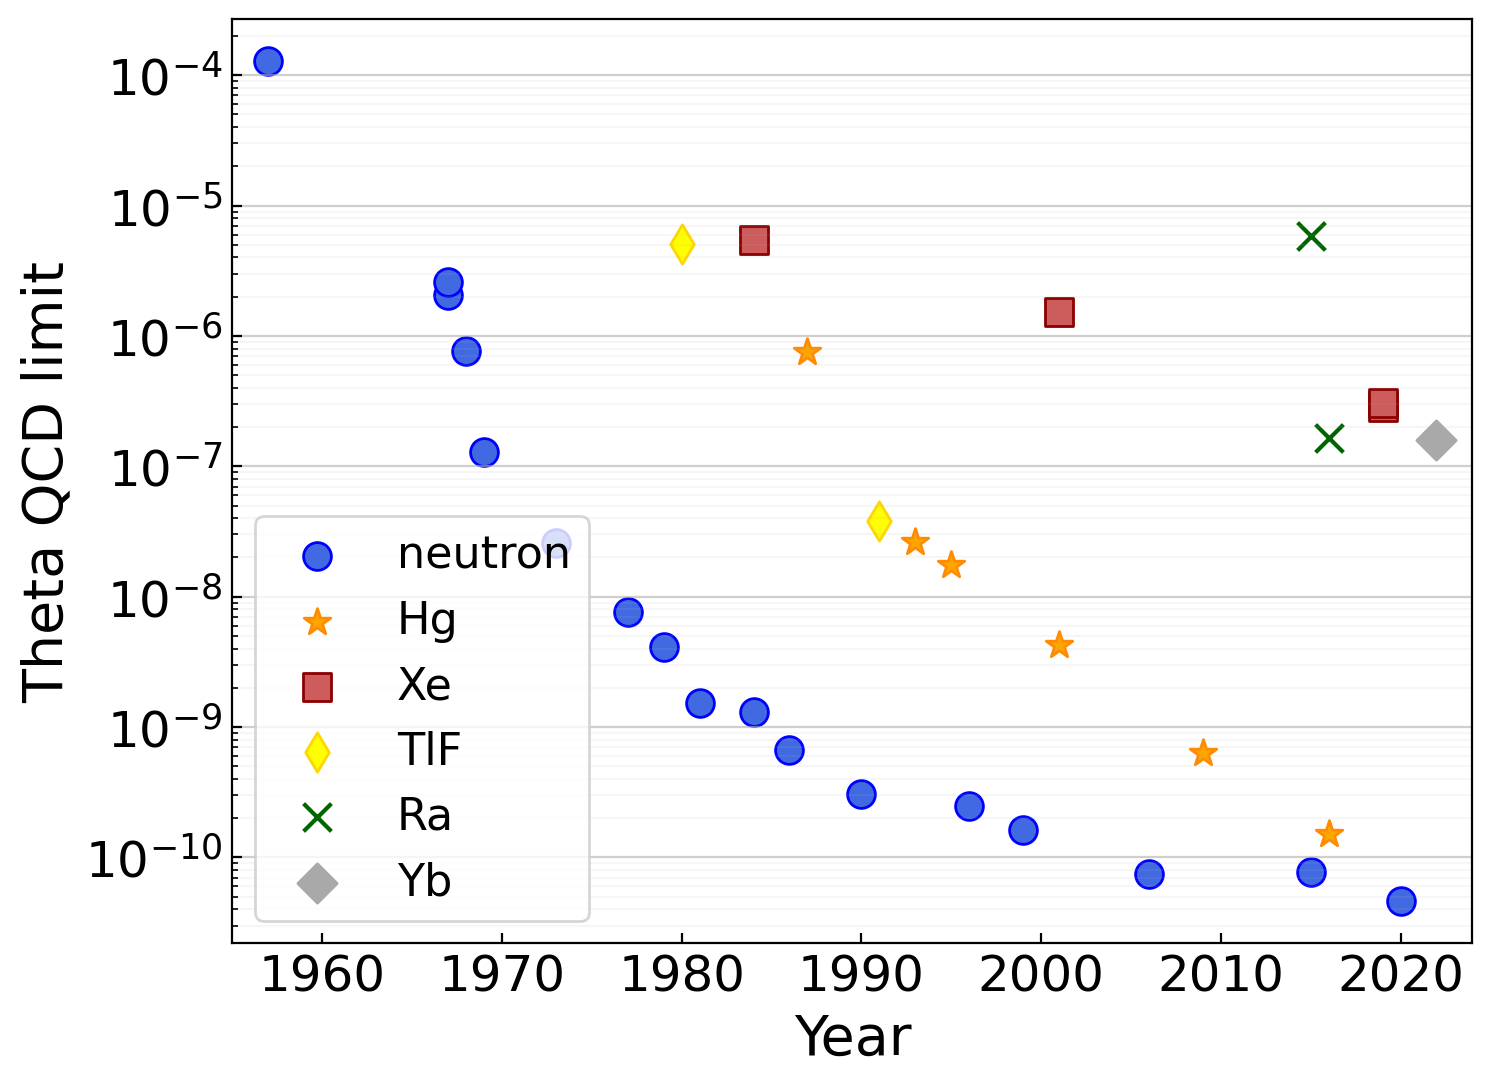

In [7]:
fig, ax = plt.subplots(figsize=(8, 6))
scatter_plot_loop(ax, hadronic_systems, "thetas")

ax.set_yscale("log")
ax.set_xlim(year_i, year_f)
ax.tick_params(axis="both", which='both', direction="in", labelsize=18)
ax.grid(axis='y', which='major', ls='-', alpha=ma_alpha)
ax.grid(axis='y', which='minor', ls='-', alpha=mi_alpha)
fontsize = 20
ax.set_xlabel("Year", fontsize=fontsize)
ax.set_ylabel("Theta QCD limit", fontsize=fontsize)
plt.legend(loc='lower left', fontsize=16)

save_figures(fig=fig, plot_title="theta-qcd-limits")

# Quark chromo EDM bounds

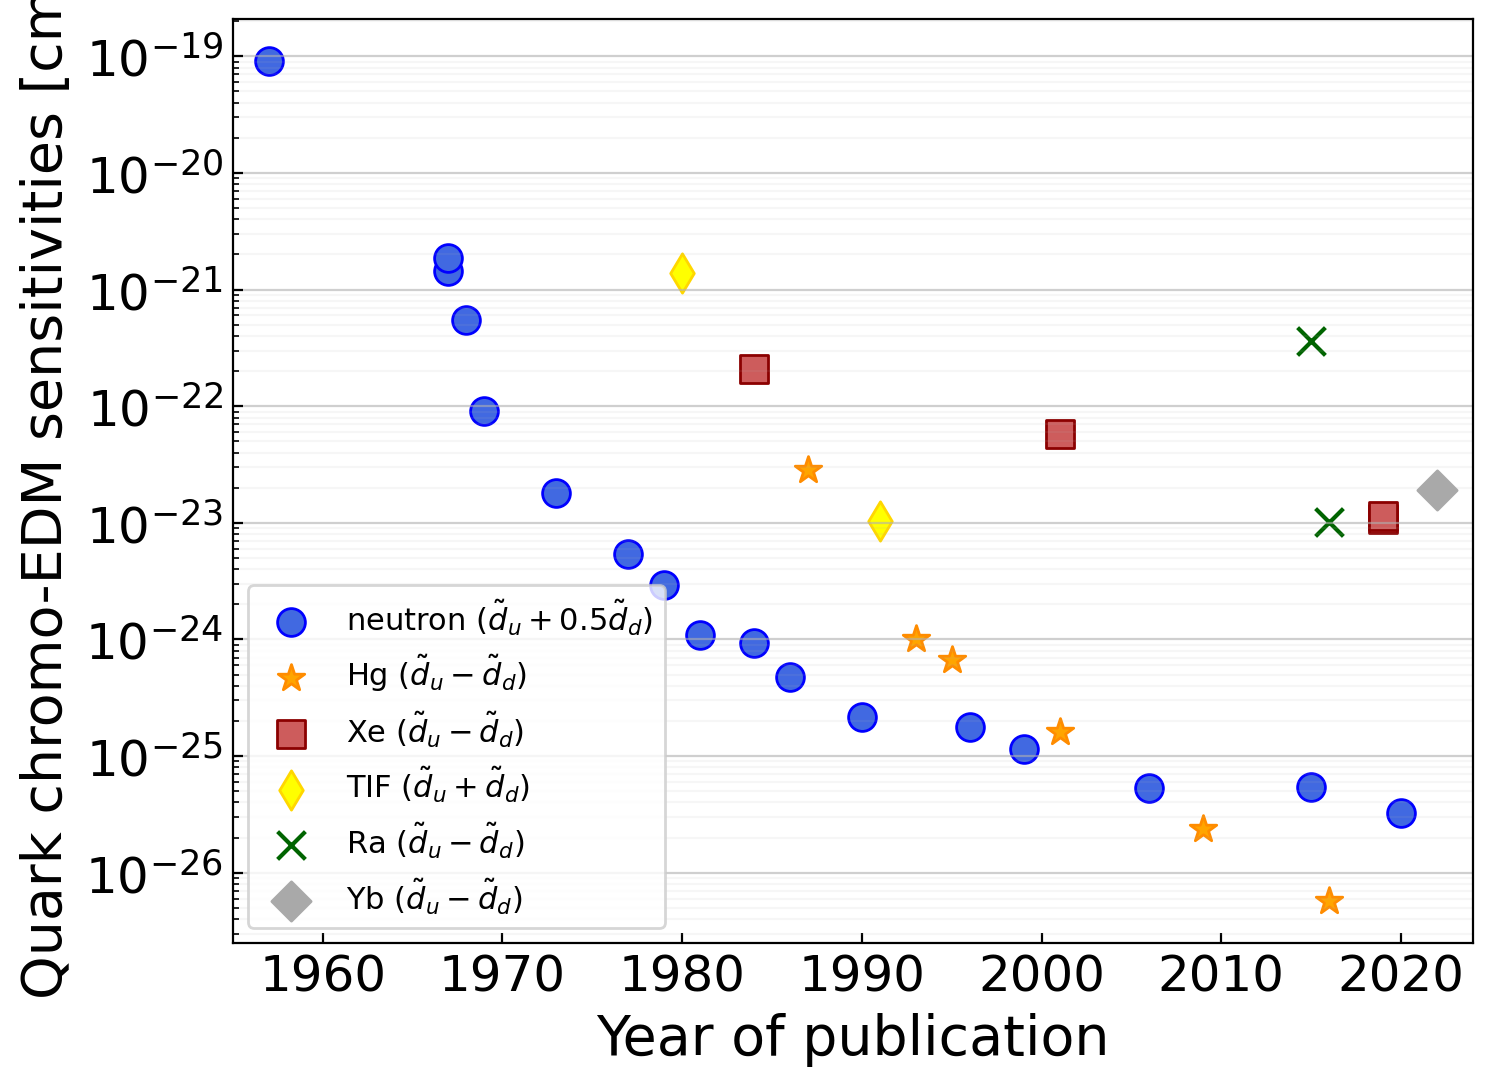

In [8]:
fig, ax = plt.subplots(figsize=(8, 6))

n_q_kwargs = _cp.deepcopy(n_kwargs)
n_q_kwargs['label'] = r"neutron ($\tilde{d}_u+0.5\tilde{d}_d$)"

hg_q_kwargs = _cp.deepcopy(hg_kwargs)
hg_q_kwargs['label'] = r"Hg ($\tilde{d}_u-\tilde{d}_d$)"

xe_q_kwargs = _cp.deepcopy(xe_kwargs)
xe_q_kwargs['label'] = r"Xe ($\tilde{d}_u-\tilde{d}_d$)"

tlf_q_kwargs = _cp.deepcopy(tlf_kwargs)
tlf_q_kwargs['label'] = r"TIF ($\tilde{d}_u+\tilde{d}_d$)"

ra_q_kwargs = _cp.deepcopy(ra_kwargs)
ra_q_kwargs['label'] = r"Ra ($\tilde{d}_u-\tilde{d}_d$)"

yb_q_kwargs = _cp.deepcopy(yb_kwargs)
yb_q_kwargs['label'] = r"Yb ($\tilde{d}_u-\tilde{d}_d$)"

ax.scatter(n_vals.years, n_vals.cedms, **n_q_kwargs)
ax.scatter(hg_vals.years, hg_vals.cedms, **hg_q_kwargs)
ax.scatter(xe_vals.years, xe_vals.cedms, **xe_q_kwargs)
ax.scatter(tlf_vals.years, tlf_vals.cedms, **tlf_q_kwargs)
ax.scatter(ra_vals.years, ra_vals.cedms, **ra_q_kwargs)
ax.scatter(yb_vals.years, yb_vals.cedms, **yb_q_kwargs)

ax.set_yscale("log")
ax.set_xlim(year_i, year_f)
ax.tick_params(axis="both", which='both', direction="in", labelsize=18)
ax.grid(axis='y', which='major', ls='-', alpha=ma_alpha)
ax.grid(axis='y', which='minor', ls='-', alpha=mi_alpha)
fontsize = 20
ax.set_xlabel("Year of publication", fontsize=fontsize)
ax.set_ylabel(r"Quark chromo-EDM sensitivities [cm]", fontsize=fontsize)
plt.legend(loc='lower left', fontsize=11)

save_figures(fig=fig, plot_title="quark-chromo-edm-limits")

# New particle mass sensitivity from chromo EDM bounds

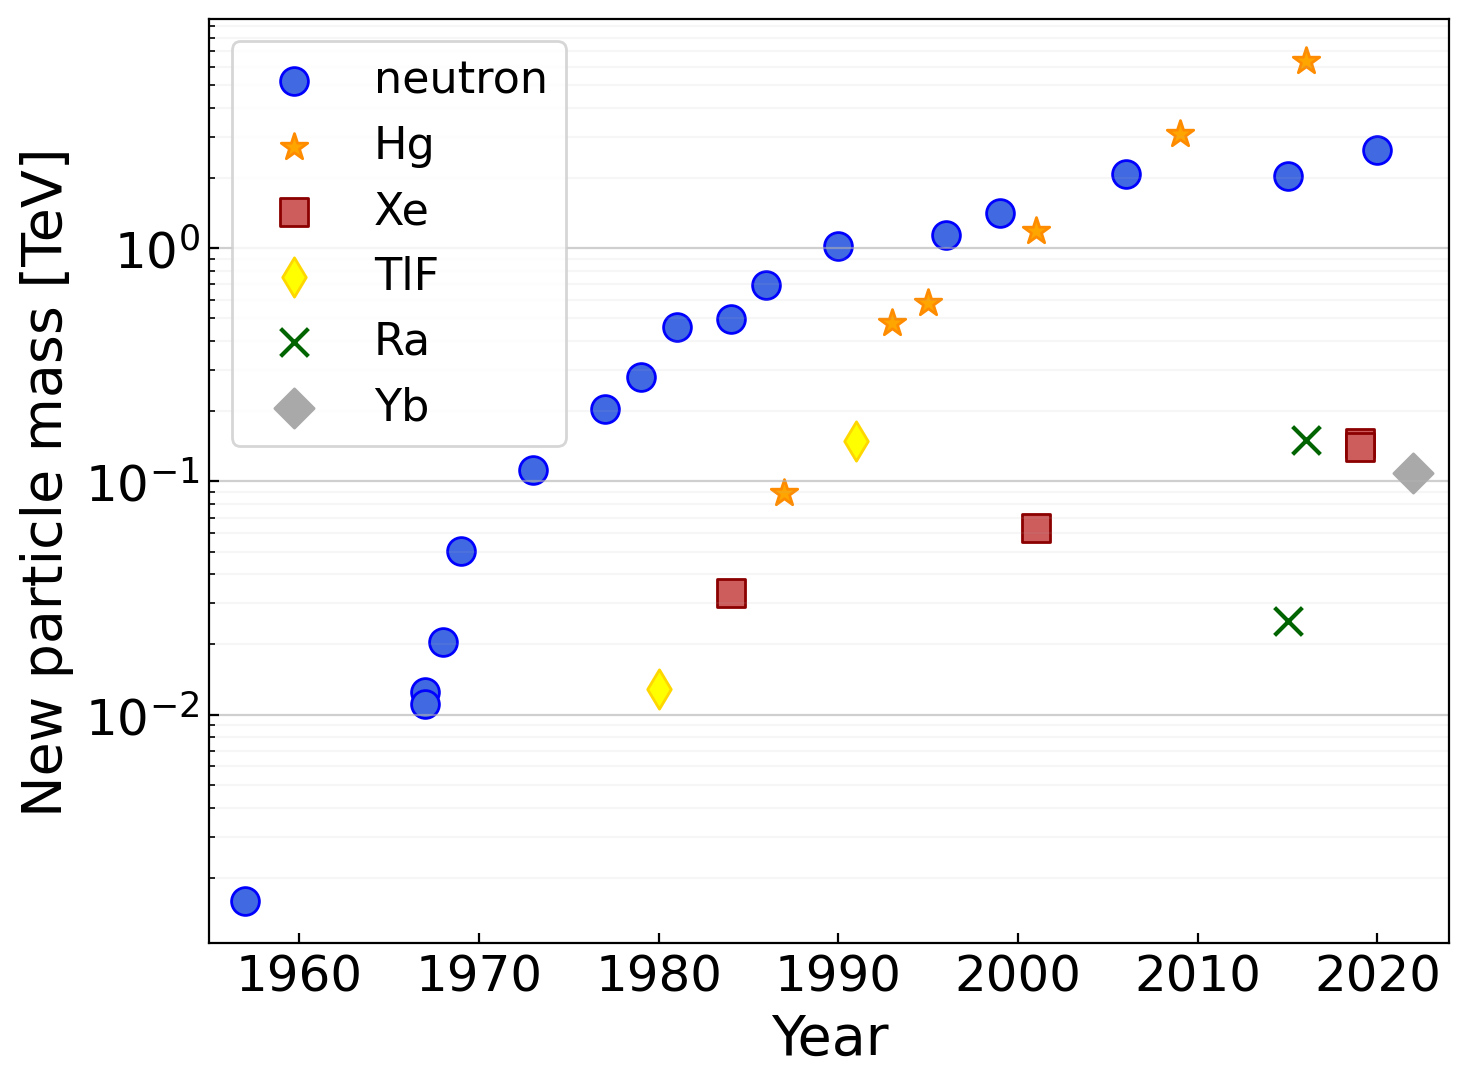

In [31]:
fig, ax = plt.subplots(figsize=(8, 6))
marker_size = 100

scatter_plot_loop(ax, hadronic_systems, "new_ms")

ax.set_yscale("log")
ax.set_xlim(year_i, year_f)

locmaj = matplotlib.ticker.LogLocator(base=10.0,  numticks=22)
ax.yaxis.set_major_locator(locmaj)

ax.tick_params(axis="both", which='both', direction="in", labelsize=18)
ax.grid(axis='y', which='major', ls='-', alpha=ma_alpha)
ax.grid(axis='y', which='minor', ls='-', alpha=mi_alpha)

plt.locator_params(axis='y', numticks=10)

locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9),numticks=12)
ax.yaxis.set_minor_locator(locmin)
ax.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())


fontsize = 20
ax.set_ylabel("New particle mass [TeV]", fontsize=fontsize)
ax.set_xlabel("Year", fontsize=fontsize)
plt.legend(loc='upper left', fontsize=16)

save_figures(fig=fig, plot_title="new-particle-limits")

# New particle mass sensitivity from chromo EDM bounds, with proposed molecular ion

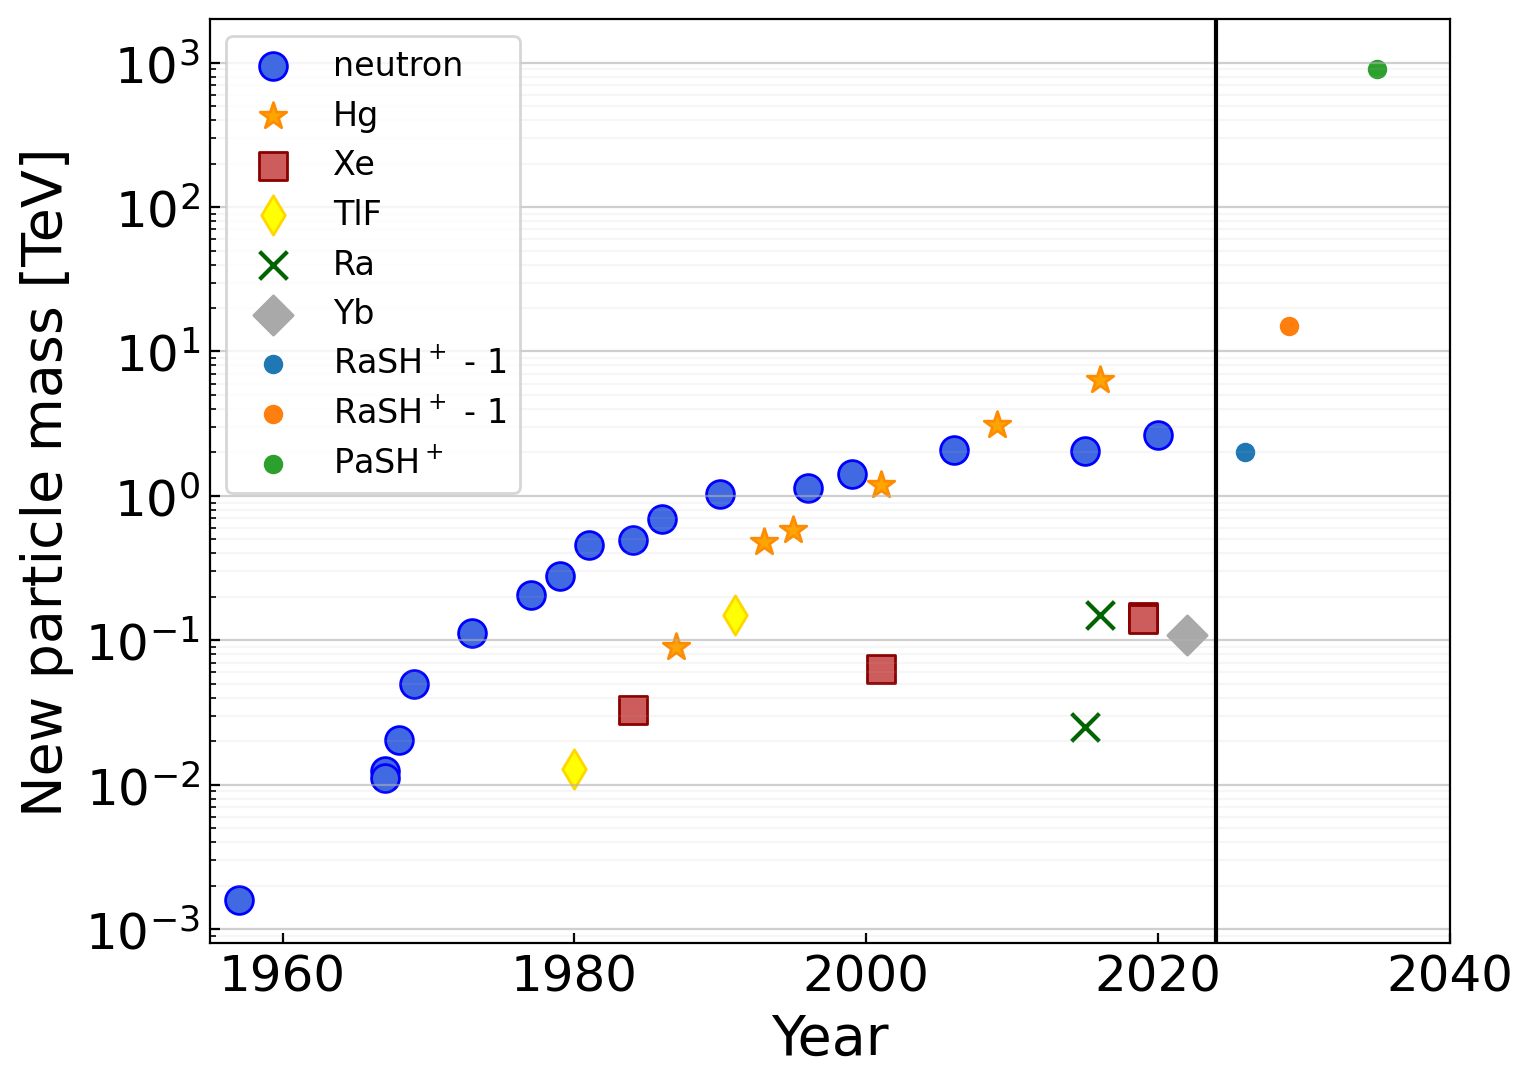

In [32]:
fig, ax = plt.subplots(figsize=(8, 6))
marker_size = 100

scatter_plot_loop(ax, hadronic_systems, "new_ms")
ax.axvline(x=2024, color='black', linestyle='-')

ax.scatter(2026, 2, label="RaSH$^+$ - 1")
ax.scatter(2029, 1.5e1, label="RaSH$^+$ - 1")
ax.scatter(2035, 9e2, label="PaSH$^+$")

ax.set_yscale("log")
ax.set_xlim(year_i, 2040)
ax.set_ylim(8e-4, 2e3)

locmaj = matplotlib.ticker.LogLocator(base=10.0,  numticks=22)
ax.yaxis.set_major_locator(locmaj)

ax.tick_params(axis="both", which='both', direction="in", labelsize=18)
ax.grid(axis='y', which='major', ls='-', alpha=ma_alpha)
ax.grid(axis='y', which='minor', ls='-', alpha=mi_alpha)

plt.locator_params(axis='y', numticks=10)

locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9),numticks=12)
ax.yaxis.set_minor_locator(locmin)
ax.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

fontsize = 20
ax.set_ylabel("New particle mass [TeV]", fontsize=fontsize)
ax.set_xlabel("Year", fontsize=fontsize)
plt.legend(loc='upper left', fontsize=12)

save_figures(fig=fig, plot_title="new-particle-limits-with-proposed_candidate")

# Electron EDM limits

## Load data
Loads the reported values for the electron EDM.

Single and two loop particle mass reach limits come from equations in Table 1 of https://arxiv.org/pdf/2203.08103.pdf

One loop mass = 48 TeV $ \times \sqrt{10^{-29} \ \mathrm{e \ cm}/d_\text{e}}$  
Two loop mass = 2 TeV $ \times \sqrt{10^{-29} \ \mathrm{e \ cm}/d_\text{e}}$  


In [ ]:
class eEDMLimit(EDMLimit):
    """Measured electron EDM limit.
    """        
    def __init__(self, year, edm_e_cm, ref):
        super().__init__(year, edm_e_cm, ref)            

    @property
    def theta_QCD(self):
        """
        The conversion from the neutron EDM limit 
        to a limit on the theta_QCD value is 
        from PRL 115, 062001 (2015), Eq. 19.
        """
        n_edm_theta_factor = 0.0039 # units of [e*fm*theta_QCD]
        factor_in_cm = n_edm_theta_factor*(1e2/1e15)
        return self.edm_e_cm/factor_in_cm

    @property
    def cEDM(self):
        """Gets the bound on chrome-EDM d_d + 0.5 d_u from a neutron EDM bound.

        Note this is not d_u - d_d as in the following cEDM bound calculations.

        See abstract of Pospelov2001 (https://arxiv.org/abs/hep-ph/0010037).
        Note that we take the prefactor 1+/-0.5 to be 1.


        Returns:
            bound of d_d + 0.5 d_u in cm.
        """
        return self.edm_e_cm/0.55

def get_eEDM_data(file_name):
    """Load eEDM data from a file.
    
    Args:
        file_name: str, file name 
        
    Returns:
        list of EDMLimit class instances
    """
    file_path = os.path.join("data", "electron", f"{file_name}")
    data = _np.genfromtxt(file_path, dtype=['<i8', '<f8', 'S11'])
    EDMs = []
    
    if data.ndim == 0:
        data = _np.expand_dims(data, axis =0)

    for measurement in data:
        year = measurement[0]
        edm_limit = measurement[1]
        one_loop = one_loop_limit_eEDM_mass_limit(edm_limit)
        two_loop = two_loop_limit_eEDM_mass_limit(edm_limit)
        ref = measurement[2]
        EDMs.append(EDMLimit(year=year, edm_e_cm=edm_limit, ref=ref))
    return EDMs


def one_loop_limit_eEDM_mass_limit(eEDM):
    """
    
    Args:
        eEDM: float, electron EDM in units of e*cm
        
    Returns:
        float, particle mass in TeV
    """
    return 48 * _np.sqrt(1e-29/eEDM)
    
    
def two_loop_limit_eEDM_mass_limit(eEDM):
    """
    
    Args:
        eEDM: float, electron EDM in units of e*cm
        
    Returns:
        float, particle mass in TeV
    """
    return 2 * _np.sqrt(1e-29/eEDM)  


HfF = get_eEDM_data(file_name="HfF.txt")
ThO = get_eEDM_data(file_name="ThO.txt")
PbO = get_eEDM_data(file_name="PbO.txt")
YbF = get_eEDM_data(file_name="YbF.txt")
TlF_eEDM = get_eEDM_data(file_name="TlF.txt")
Tl = get_eEDM_data(file_name="Tl.txt")
Hg_eEDM = get_eEDM_data(file_name="Hg.txt")
Xe_eEDM = get_eEDM_data(file_name="Xe.txt")
Rb = get_eEDM_data(file_name="Rb.txt")
Cs = get_eEDM_data(file_name="Cs.txt")
He = get_eEDM_data(file_name="He.txt")
Lamb = get_eEDM_data(file_name="Lamb.txt")
g_factor = get_eEDM_data(file_name="g_factor.txt")

In [ ]:
class ElectronPlottables:
    def __init__(self, eEDMs):
        """
        Attributes:
            edms, 
        
        Args:
            eEDMs, list of EDM instances
        """
        self.years = []
        self.edms = []
        self.one_loop = []
        self.two_loop = []
        self.populate_lists(EDMs=eEDMs)
        self.kwargs = None
    
    def populate_lists(self, EDMs):
        for edm in EDMs:
            self.years.append(edm.year)
            self.edms.append(edm.edm_e_cm)
            one_loop = one_loop_limit_eEDM_mass_limit(edm.edm_e_cm)
            self.one_loop.append(one_loop)
            two_loop = two_loop_limit_eEDM_mass_limit(edm.edm_e_cm)
            self.two_loop.append(two_loop)
            

HfF_kwargs = {'marker':"d", 'color':"hotpink", 'label':"HfF+", 
            's':100, 'edgecolor':"crimson"}
ThO_kwargs = {'marker':"o", 'color':"yellowgreen", 'label':"ThO", 
            's':100, 'edgecolor':"darkgreen"}
He_kwargs = {'marker':"D", 'color':"yellowgreen", 'label':"He scattering", 
            's':100, 'edgecolor':"green"}
PbO_kwargs = {'marker':">", 'color':"purple", 'label':"PbO", 
            's':100, 'edgecolor':"indigo"}
YbF_kwargs = {'marker':"X", 'color':"cyan", 'label':"YbF", 
            's':100, 'edgecolor':"darkcyan"}
Tl_kwargs = {'marker':"s", 'color':"royalblue", 'label':"Tl", 's':100, 'edgecolor':"b"}
Rb_kwargs = {'marker':"H", 'color':"thistle", 'label':"Rb", 
            's':100, 'edgecolor':"violet"}
Cs_kwargs = {'marker':"<", 'color':"grey", 'label':"Cs", 
            's':100, 'edgecolor':"black"}
Lamb_kwargs = {'marker':"p", 'color':"peru", 'label':"Lamb shift", 
            's':100, 'edgecolor':"sienna"}
g_factor_kwargs = {'marker':"^", 'color':"orange", 'label':"g factor", 
            's':100, 'edgecolor':"orange"}
            
HfF_vals = ElectronPlottables(HfF)
HfF_vals.kwargs = HfF_kwargs
ThO_vals = ElectronPlottables(ThO)
ThO_vals.kwargs = ThO_kwargs
PbO_vals = ElectronPlottables(PbO)
PbO_vals.kwargs = PbO_kwargs
YbF_vals = ElectronPlottables(YbF)
YbF_vals.kwargs = YbF_kwargs
TlF_eEDM_vals = ElectronPlottables(TlF_eEDM)
TlF_eEDM_vals.kwargs = tlf_vals.kwargs
Tl_vals = ElectronPlottables(Tl)
Tl_vals.kwargs = Tl_kwargs
Hg_eEDM_vals = ElectronPlottables(Hg_eEDM)
Hg_eEDM_vals.kwargs = hg_vals.kwargs
Xe_eEDM_vals = ElectronPlottables(Xe_eEDM)
Xe_eEDM_vals.kwargs = xe_vals.kwargs
Rb_vals = ElectronPlottables(Rb)
Rb_vals.kwargs = Rb_kwargs
Cs_vals = ElectronPlottables(Cs)
Cs_vals.kwargs = Cs_kwargs
He_vals = ElectronPlottables(He)
He_vals.kwargs = He_kwargs
Lamb_vals = ElectronPlottables(Lamb)
Lamb_vals.kwargs = Lamb_kwargs
g_factor_vals = ElectronPlottables(g_factor)
g_factor_vals.kwargs = g_factor_kwargs

electron_systems = [HfF_vals, ThO_vals, PbO_vals, YbF_vals, TlF_eEDM_vals, Tl_vals, Hg_eEDM_vals, 
                   Xe_eEDM_vals, Rb_vals, Cs_vals, He_vals, Lamb_vals, g_factor_vals]

# electron EDM Limits

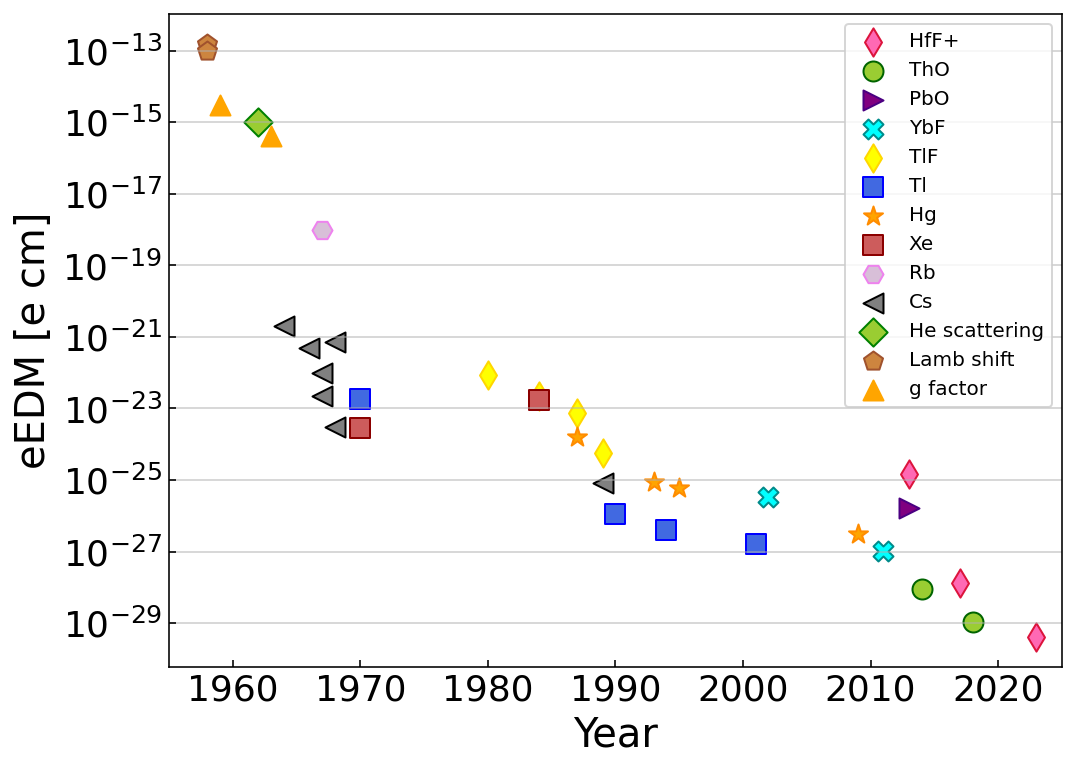

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))

scatter_plot_loop(ax, electron_systems, "edms")

ax.set_yscale("log")
ax.set_xlim(year_i, year_f_electron)

locmaj = matplotlib.ticker.LogLocator(base=10.0,  numticks=22)
ax.yaxis.set_major_locator(locmaj)

ax.tick_params(axis="both", which='both', direction="in", labelsize=18)
ax.grid(axis='y', which='major', ls='-', alpha=ma_alpha)
ax.grid(axis='y', which='minor', ls='-', alpha=mi_alpha)

plt.locator_params(axis='y', numticks=10)

locmin = matplotlib.ticker.LogLocator(base=10.0, subs=(0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9), numticks=12)
ax.yaxis.set_minor_locator(locmin)
ax.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())


fontsize = 20
ax.set_xlabel("Year", fontsize=fontsize)
ax.set_ylabel("eEDM [e cm]", fontsize=fontsize)
ax.legend(numpoints=1, fontsize=10)

save_figures(fig=fig, plot_title="electron-edm-limits")

# New particle mass sensitivity from electron EDM bounds

## Single loop sensitivity

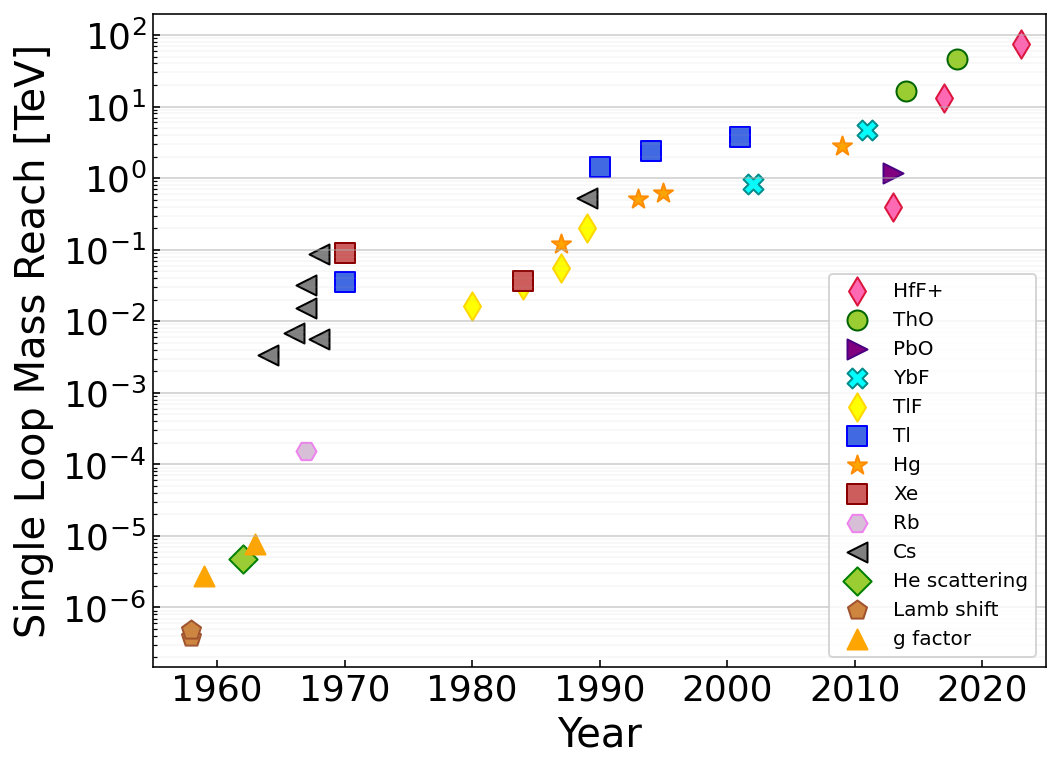

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))

scatter_plot_loop(ax, electron_systems, "one_loop")

ax.set_yscale("log")
ax.set_xlim(year_i, year_f_electron)

locmaj = matplotlib.ticker.LogLocator(base=10.0,  numticks=22)
ax.yaxis.set_major_locator(locmaj)

ax.tick_params(axis="both", which='both', direction="in", labelsize=18)
ax.grid(axis='y', which='major', ls='-', alpha=ma_alpha)
ax.grid(axis='y', which='minor', ls='-', alpha=mi_alpha)

plt.locator_params(axis='y', numticks=10)

locmin = matplotlib.ticker.LogLocator(base=10.0, subs=(0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9), numticks=12)
ax.yaxis.set_minor_locator(locmin)
ax.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())


fontsize = 20
ax.set_xlabel("Year", fontsize=fontsize)
ax.set_ylabel("Single Loop Mass Reach [TeV]", fontsize=fontsize)
ax.legend(numpoints=1, fontsize=10)#, framealpha=1)

save_figures(fig=fig, plot_title="e-edm-1-loop")

## Two loop sensitivity

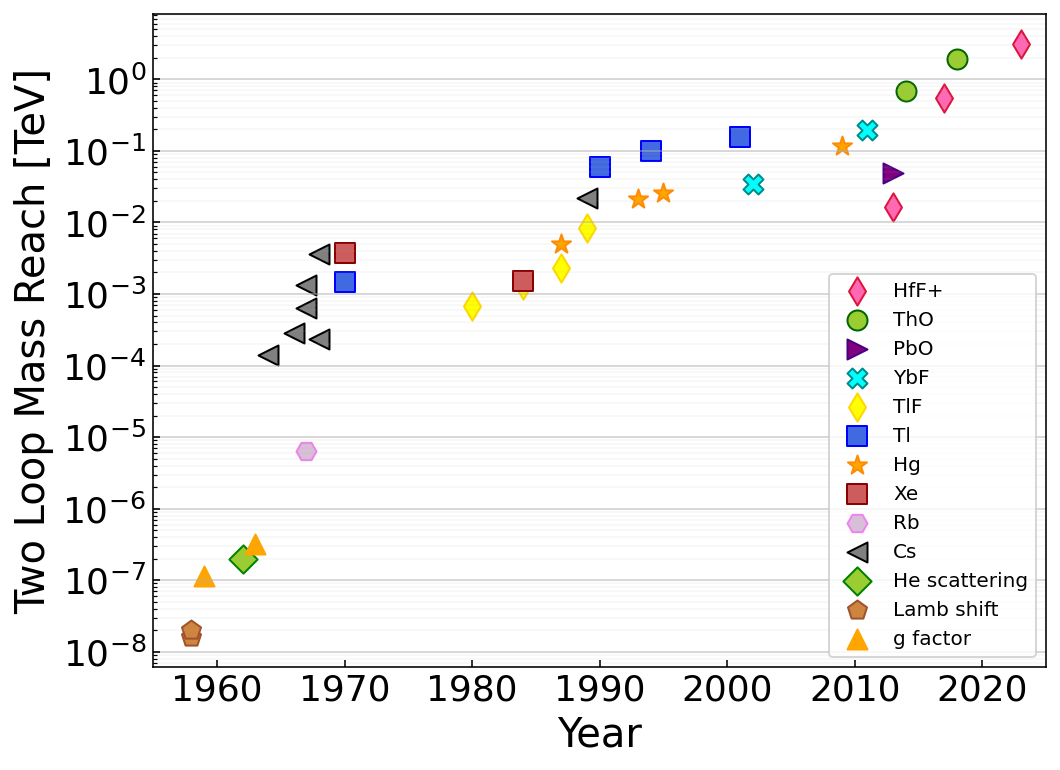

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))

scatter_plot_loop(ax, electron_systems, "two_loop")

ax.set_yscale("log")
ax.set_xlim(year_i, year_f_electron)

locmaj = matplotlib.ticker.LogLocator(base=10.0,  numticks=22)
ax.yaxis.set_major_locator(locmaj)

ax.tick_params(axis="both", which='both', direction="in", labelsize=18)
ax.grid(axis='y', which='major', ls='-', alpha=ma_alpha)
ax.grid(axis='y', which='minor', ls='-', alpha=mi_alpha)

plt.locator_params(axis='y', numticks=10)

locmin = matplotlib.ticker.LogLocator(base=10.0, subs=(0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9), numticks=12)
ax.yaxis.set_minor_locator(locmin)
ax.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())


fontsize = 20
ax.set_xlabel("Year", fontsize=fontsize)
ax.set_ylabel("Two Loop Mass Reach [TeV]", fontsize=fontsize)
ax.legend(numpoints=1, fontsize=10)

save_figures(fig=fig, plot_title="e-edm-2-loop")